# Exploratory Data Analysis

In [1]:
# load and view a .npy file
import numpy as np
from matplotlib import pyplot as plt
import sys
# load the .npy file
initial_inputs = np.load("initial_inputs.npy")
initial_outputs = np.load("initial_outputs.npy")
# summarize shape
print(initial_inputs.shape)
print(initial_outputs.shape)

# create a dataframe from inputs and outputs
import pandas as pd
data = pd.DataFrame(initial_inputs, columns=[f'input_{i}' for i in range(initial_inputs.shape[1])])
data['output'] = initial_outputs
print(data.head())

(30, 4)
(30,)
    input_0   input_1   input_2   input_3     output
0  0.896981  0.725628  0.175404  0.701694 -22.108288
1  0.889356  0.499588  0.539269  0.508783 -14.601397
2  0.250946  0.033693  0.145380  0.494932 -11.699932
3  0.346962  0.006250  0.760564  0.613024 -16.053765
4  0.124871  0.129770  0.384400  0.287076 -10.069633


## Observations


# Gaussian Process with EI, PI and UCB

Next (UCB): [0.39490654 0.42643614 0.35274235 0.42069461]
Next (EI):  [0.49654987 0.50184189 0.01230831 0.42816807]
Next (PI):  [0.49654987 0.50184189 0.01230831 0.42816807]


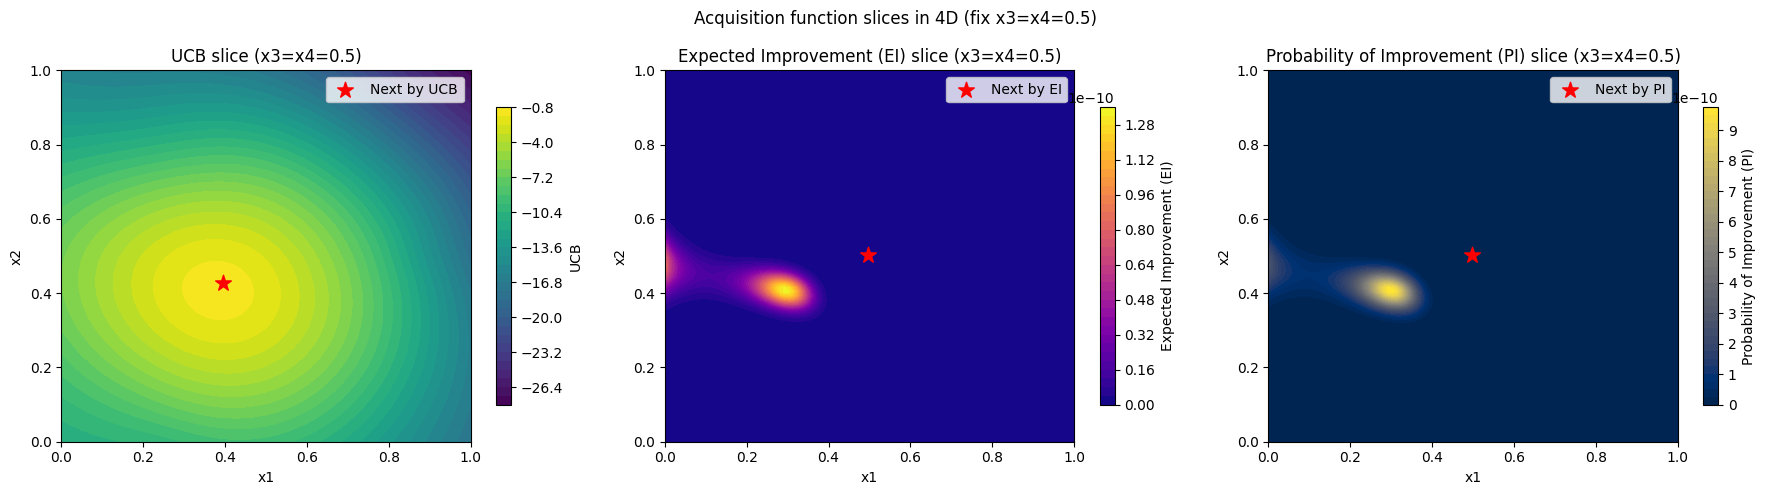

In [3]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.stats import norm, qmc  # norm for EI/PI, qmc for Latin Hypercube

# ----------------------------------------------------------
# 1) GP model utilities
# ----------------------------------------------------------
def fit_gp(X, y):
    """
    Fit a Gaussian Process with ARD RBF kernel on 4D inputs.
    Assumes X is scaled to [0,1]^4 (recommended).
    """
    kernel = C(1.0, (1e-3, 1e3)) * RBF(
        length_scale=[0.3, 0.3, 0.3, 0.3],
        length_scale_bounds=(1e-2, 1e2)
    )
    gp = GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=5,
        alpha=1e-4,          # small noise term; tune for your data
        normalize_y=True
    )
    gp.fit(X, y)
    return gp

def compute_acquisitions(gp, Xcand, best_y=None, xi=0.01, kappa=2.0):
    """
    Compute UCB, EI, PI for candidate points.
    - gp: fitted GaussianProcessRegressor
    - Xcand: candidate points (m×4) in [0,1]^4
    - best_y: current best observed output (if None, take max of training y)
    - xi: small improvement margin for EI/PI
    - kappa: exploration weight for UCB
    Returns: (ucb, ei, pi, mean, std)
    """
    mean, std = gp.predict(Xcand, return_std=True)
    std = np.maximum(std, 1e-12)  # numerical safety (avoid divide-by-zero)

    if best_y is None:
        best_y = np.max(gp.y_train_)  # since normalize_y=True, this is okay for selection

    # UCB: mu + kappa*sigma
    ucb = mean + kappa * std

    # EI: (mu - best - xi) * Phi(z) + sigma * phi(z)
    z  = (mean - best_y - xi) / std
    ei = (mean - best_y - xi) * norm.cdf(z) + std * norm.pdf(z)

    # PI: Phi(z)
    pi = norm.cdf(z)

    return ucb, ei, pi, mean, std

def choose_next(Xcand, acq_values):
    """Return next point by maximizing the acquisition."""
    idx = int(np.argmax(acq_values))
    return Xcand[idx], idx

# ----------------------------------------------------------
# 2) Slice visualisation utilities (2D views in a 4D space)
# ----------------------------------------------------------
def make_slice(gp, which='12', grid=100, fixed=(0.5, 0.5), xi=0.01, kappa=2.0):
    """
    Compute a 2D slice of UCB, EI, PI.
    which='12' -> slice over (x1,x2) with (x3,x4)=fixed
    which='34' -> slice over (x3,x4) with (x1,x2)=fixed
    Returns (X1, X2, UCB_slice, EI_slice, PI_slice)
    """
    x = np.linspace(0, 1, grid)
    X1, X2 = np.meshgrid(x, x)
    if which == '12':
        Xslice = np.column_stack([
            X1.ravel(), X2.ravel(),
            np.full(grid*grid, fixed[0]), np.full(grid*grid, fixed[1])
        ])
    else:
        Xslice = np.column_stack([
            np.full(grid*grid, fixed[0]), np.full(grid*grid, fixed[1]),
            X1.ravel(), X2.ravel()
        ])
    ucb, ei, pi, _, _ = compute_acquisitions(gp, Xslice, xi=xi, kappa=kappa)
    return X1, X2, ucb.reshape(grid, grid), ei.reshape(grid, grid), pi.reshape(grid, grid)

#-------------------- Main Program --------------------

# Load the dataset
X = np.load("initial_inputs.npy")
y = np.load("initial_outputs.npy")

# Fit GP
gp = fit_gp(X, y)

# Candidate set via Latin Hypercube in [0,1]^4
M = 6000
sampler = qmc.LatinHypercube(d=4, seed=123)
Xcand = sampler.random(M)

# Compute acquisitions and pick next points for UCB, EI, PI
kappa = 2.0  # ↑ explore; ↓ exploit
xi    = 0.01 # small margin for EI/PI
ucb_vals, ei_vals, pi_vals, _, _ = compute_acquisitions(gp, Xcand, xi=xi, kappa=kappa)
next_ucb, idx_ucb = choose_next(Xcand, ucb_vals)
next_ei,  idx_ei  = choose_next(Xcand, ei_vals)
next_pi,  idx_pi  = choose_next(Xcand, pi_vals)

print("Next (UCB):", next_ucb)
print("Next (EI): ", next_ei)
print("Next (PI): ", next_pi)

# ---- Visualise acquisition slices over (x1, x2) at (x3, x4) = 0.5 ----
X1, X2, UCB_s, EI_s, PI_s = make_slice(
    gp, which='12', grid=100, fixed=(0.5, 0.5), xi=xi, kappa=kappa
)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
cmaps  = ['viridis', 'plasma', 'cividis']
labels = ['UCB', 'Expected Improvement (EI)', 'Probability of Improvement (PI)']
arrays = [UCB_s, EI_s, PI_s]

for ax, arr, lab, cmap in zip(axes, arrays, labels, cmaps):
    cs = ax.contourf(X1, X2, arr, levels=40, cmap=cmap)
    ax.set_xlabel('x1'); ax.set_ylabel('x2'); ax.set_title(lab + ' slice (x3=x4=0.5)')
    fig.colorbar(cs, ax=ax, shrink=0.8, label=lab)

# Overlay the projected best-next points onto this slice
axes[0].scatter(next_ucb[0], next_ucb[1], c='red', marker='*', s=140, label='Next by UCB')
axes[1].scatter(next_ei[0],  next_ei[1],  c='red', marker='*', s=140, label='Next by EI')
axes[2].scatter(next_pi[0],  next_pi[1],  c='red', marker='*', s=140, label='Next by PI')
for ax in axes:
    ax.legend(loc='upper right')

plt.suptitle('Acquisition function slices in 4D (fix x3=x4=0.5)')
plt.tight_layout()
plt.savefig('acq_slices_4d.png')  # saved image file
plt.show()


# Week 1 Submission
0.496549-0.501841-0.012308-0.428168